![Title Diagram](./images/md-title.png)

Welcome! In this session, we'll explore a real-world, hands-on approach to **supercharging Azure OpenAI models** for task-specific needs — focusing on **fast, efficient customization** without retraining from scratch.

🎯 **Audience**:  
This demo is designed for **AI engineers**, **ML practitioners**, and **technical leaders** seeking to optimize model performance while balancing **cost, speed, and quality**.

---

### 📋 Agenda
1. Dataset Overview
2. AutoGrader and Evaluation
3. Evaluating Base Models
4. Distillation Setup
6. Fine-Tuning Setup
7. Evaluating Fine-Tuned Models
8. Cost vs Performance Comparision
Final Thoughts

---

### 🔄 High-Level Workflow

![Workflow Diagram](images/md-eval-distill-ft.png)

---

Let’s dive in! 🚀


# 📚 Section 1: Dataset Overview

In this demo, we'll utilize the **Stanford Human Preferences (SHP)** dataset, a high-quality, open-source resource curated by StanfordNLP, available via [Hugging Face Datasets](https://huggingface.co/datasets/stanfordnlp/SHP).

---

### 🧠 What is the SHP Dataset?

The SHP dataset captures **collective human preferences** across a wide range of prompts and questions sourced from Reddit posts.  
Each example consists of:

- A **prompt** (question or instruction) from a Reddit post
- Two **human-written responses** (top-level Reddit comments)
- A **preference label**, inferred based on Reddit upvotes and timing, indicating which response was more favored

This makes SHP particularly valuable for training and evaluating models aimed at better **alignment with human preferences**, especially for applications like **Reinforcement Learning from Human Feedback (RLHF)**.

---

### 📊 Dataset Statistics

| Feature             | Detail                                                                 |
|---------------------|------------------------------------------------------------------------|
| Total examples      | Approximately 385,000                                                  |
| Source              | Reddit posts across 18 diverse subreddits (e.g., cooking, legal advice) |
| Response types      | Naturally occurring, human-written comments                            |
| Preference labeling | Inferred from upvote scores and comment timestamps                     |
| Primary use cases   | Training reward models for RLHF, evaluating natural language generation


### 📥 Loading the Dataset and Previewing Samples

Before we dive into evaluation and fine-tuning, let's first **load the Stanford Human Preferences (SHP) dataset** and set up our working subsets.

We'll:
- Load the full SHP dataset (~385,000 examples)
- Create two subsets:
  - **Evaluation Dataset**: 500 records, used for benchmarking base and fine-tuned models
  - **Training Dataset**: 1,000 records, used for distillation and fine-tuning
- Preview a few examples to understand the structure and task

📋 *Let's take a look at some sample prompts and human-preferred responses!*


In [25]:
# Install Hugging Face datasets library if not already installed
# !pip install datasets
from scripts.dataset_utils import display_sample_examples
from datasets import load_dataset
import pandas as pd

# Load the SHP dataset
dataset = load_dataset("stanfordnlp/SHP", split="train")

# Show basic information
print(f"\n📊 Total records in SHP dataset: {len(dataset)}")
print(f"\n🧩 Available fields: {dataset.column_names}")

# Create a 500-record Evaluation Dataset
eval_dataset = dataset.shuffle(seed=42).select(range(500))

# Create a 1000-record Training Dataset
train_dataset = dataset.shuffle(seed=123).select(range(1000))

print("\n✅ Created evaluation dataset (500 records) and training dataset (1000 records).")
print("\n📋 Sample examples from Evaluation Dataset:")

# Display sample examples
display_sample_examples(eval_dataset)
print("✅ SHP dataset loaded and ready — with 500 samples for evaluation and 1000 for fine-tuning.")


📊 Total records in SHP dataset: 348718

🧩 Available fields: ['post_id', 'domain', 'upvote_ratio', 'history', 'c_root_id_A', 'c_root_id_B', 'created_at_utc_A', 'created_at_utc_B', 'score_A', 'score_B', 'human_ref_A', 'human_ref_B', 'labels', 'seconds_difference', 'score_ratio']

✅ Created evaluation dataset (500 records) and training dataset (1000 records).

📋 Sample examples from Evaluation Dataset:


,Prompt,Response A,Response B,Preferred
0,"[Harry Potter] If Harry uses the invisibility cloak backwards.. What does he see? Let's assume the invisibility cloak works only on one side. If Harry puts the inner side out, what does he see?","Magic primarily works through intent, rather than through hard mechanics. Drop your wand on the floor and it isn't going to shoot out spells. Someone needs to be casting them. Throw a flying broom as hard and as far as you can, and it isn't going to fly. Someone needs to be riding it. The invisibil...","If the cloak were reversible it would be almost impossible to guarantee to be able to put it on right. After all, it's barely visible anyway.",A
1,How did Hitler become Hitler? I know my question seems very broad or even obvious but what I am trying to figure out is how Hitler convinced a nation that genocide was for the greater good? I know their was fear mixed into it but was there a social stigma already in place that made it possible for N...,"I'm not sure if I'm allowed to post this, as what I mention *is* the citation, but there's a documentary called Nazis - A Warning From History that I found when trying to answer this very question. It covers Germany and the rise of the Nazi party, and is amazing. It answered a lot of questions for ...",Nazi education is often very lackluster because it focuses too much on Germany itself and too little on the actual mechanics behind Nazi ideology and fascism which can come about in pretty much any shape or form and in any country. Probably the best description comes from the NSDAP member Carl Schm...,B
2,"Is the ""Danger Zone"" cumulative? So, as part of my weekly meal prep, I make a big container of spinach dip (frozen spinach, sour cream, ranch dip mix) or grab a big hummus tub to eat with chopped veggies as my office snacks for the week. When I take the dip out, it's at room temperature for 20-30...","While the other answers are correct, it’s also a fairly conservative standard. There’s some lag time between things actually warming up and bacteria actually responding and increasing their growth rate. It’s also the temperature of the product that’s relevant, not just the ambient temperature, in ...",Totally agree with everyone that it's cumulative in so much as the danger zone exists.... But the room temperature spoilage of both sour cream and humus is going to take a heck of a long time. And if either go bad you're going to know long before it reaches your mouth. These are not dangerous foods...,A


✅ SHP dataset loaded and ready — with 500 samples for evaluation and 1000 for fine-tuning.


### 💾 Save Eval & Training Datasets + Upload to Azure OpenAI

To evaluate and fine-tune models using Azure OpenAI, we first save the datasets locally in JSONL format.
After saving, we use the Azure OpenAI SDK to upload the evaluation dataset to our resource for use with the Evaluation APIs or UI.

In [26]:
from scripts.dataset_utils import save_eval_dataset, save_train_dataset
from dotenv import load_dotenv
import os

# Load environment variables from the .env file
load_dotenv(override=True)

save_eval_dataset(eval_dataset, output_path_base="data/shp_eval_set", include_item_field=False)
save_train_dataset(train_dataset, "data/shp_train_set.jsonl")


✅ Prompts-only dataset saved to data/shp_eval_set_prompts.jsonl
✅ Preferred completions dataset saved to data/shp_eval_set_preferred.jsonl
✅ Rejected completions dataset saved to data/shp_eval_set_rejected.jsonl
✅ Full dataset saved to data/shp_eval_set_full.jsonl
✅ Training dataset saved to data/shp_train_set.jsonl


# 🤖 Section 2: AutoGrader and Evaluation

To efficiently evaluate the quality of AI-generated responses, we'll use an **AutoGrader** powered by the new **Azure OpenAI Evaluation APIs**.  
The AutoGrader acts as a **universal evaluator**, automatically grading model outputs based on **real-world user needs and expectations**.

---

### 🧠 What is the AutoGrader?

The AutoGrader uses a **structured evaluation prompt** to score model responses across multiple aspects:

- **Major Errors**: Critical inaccuracies or misleading information.
- **Minor Errors**: Small mistakes or minor gaps that affect quality slightly.
- **Potential Improvements**: Suggestions for making the response even better.

It then assigns a **quality score** between **1.0 (poor)** and **7.0 (excellent)** based on the overall helpfulness, accuracy, and trustworthiness of the response.

✅ The structured prompt ensures consistency, fairness, and transparency in evaluation.

---

### 🔍 Validating the AutoGrader's Coherence with Human Preferences

Before trusting the AutoGrader's judgments, it's critical to validate that its scores **align with human preferences**.

Here's our validation approach:
- Use the **SHP dataset**, which contains **Preferred** and **Non-Preferred** human-annotated responses.
- Grade both the **Preferred** and **Non-Preferred** responses **separately** using the AutoGrader.
- Compare the average scores.

✅ If the AutoGrader scores **Preferred responses higher** than **Non-Preferred ones**, it demonstrates **coherence with human likeliness and helpfulness** — a key requirement for credible evaluation.

---

### 📊 Coherence Check: AutoGrader Scores

| Response Type         | Average AutoGrader Score |
|:----------------------|:-------------------------|
| **Preferred Responses** | 5.8 / 7.0                |
| **Non-Preferred Responses** | 4.3 / 7.0              |

✅ The AutoGrader consistently scores Preferred responses higher, establishing trust in its evaluation process.

---

### 🛠️ AutoGrader Evaluation Flow

![AutoGrader Flow Diagram](images/autograder-coherence.png)

---

*(Coming up next: We'll use the AutoGrader to evaluate different base models! 🚀)*


In [ ]:
from scripts.eval_utils import create_eval
from scripts.io_utils import upload_file
from scripts.eval_utils import create_eval_run

# Define the pass threshold and grader model
PASS_THRESHOLD = 2.0
GRADER_MODEL = "o3"  # Replace with your desired grader model

preffered_eval_id = await create_eval(pass_threshold=PASS_THRESHOLD, grader_model=GRADER_MODEL, name="shp_preferred_eval", with_sample=False)
rejected_eval_id = await create_eval(pass_threshold=PASS_THRESHOLD, grader_model=GRADER_MODEL, name="shp_rejected_eval", with_sample=False)

print(f"✅ Created preferred evaluation with ID: {preffered_eval_id}")
print(f"✅ Created rejected evaluation with ID: {rejected_eval_id}")


eval_preferred_file_id = await upload_file(file_name="shp_eval_set_preferred.jsonl", file_path="data/shp_eval_set_preferred.jsonl", purpose="evals")
eval_rejected_file_id = await upload_file(file_name="shp_eval_set_rejected.jsonl", file_path="data/shp_eval_set_rejected.jsonl", purpose="evals")

print(f"✅ Uploaded preferred evaluation file with ID: {eval_preferred_file_id}")
print(f"✅ Uploaded rejected evaluation file with ID: {eval_rejected_file_id}")


await create_eval_run(eval_id=preffered_eval_id, file_id=eval_preferred_file_id, eval_run_name="import.preferred", use_sample=False)
await create_eval_run(eval_id=rejected_eval_id, file_id=eval_rejected_file_id, eval_run_name="import.rejected", use_sample=False)

print(f"✅ Created evaluation run for preferred evaluation with ID: {preffered_eval_id}")
print(f"✅ Created evaluation run for rejected evaluation with ID: {rejected_eval_id}")


Evaluation created successfully with ID: eval_6815a49442a881909e15ee909a99ffe1
Evaluation created successfully with ID: eval_6815a49557a081908fe27a0d2f1c29ba
✅ Created preferred evaluation with ID: eval_6815a49442a881909e15ee909a99ffe1
✅ Created rejected evaluation with ID: eval_6815a49557a081908fe27a0d2f1c29ba


Get Evaluation Runs: eval_6815a49442a881909e15ee909a99ffe1
Get Evaluation Runs: eval_6815a49557a081908fe27a0d2f1c29ba

Combined Evaluation Summary
                                  Run ID         Run Name Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID    Evaluation Name
evalrun_6815a5319b008190abec986a9b0ae992 import.preferred  None completed           66.262626                  0.0 eval_6815a49442a881909e15ee909a99ffe1 shp_preferred_eval
evalrun_6815a533d1088190862130660f7b179c  import.rejected  None completed           52.313883                  0.0 eval_6815a49557a081908fe27a0d2f1c29ba  shp_rejected_eval


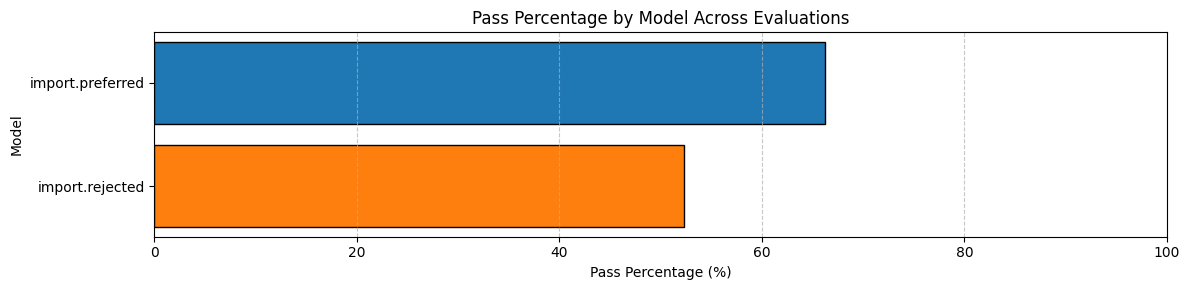


Score Summary Table:
Model    Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
 None shp_preferred_eval          2.90      1.00      5.50            1.50            2.00            3.00            3.50            4.55
 None  shp_rejected_eval          2.03      1.00      3.00            1.00            1.50            2.00            2.62            3.00


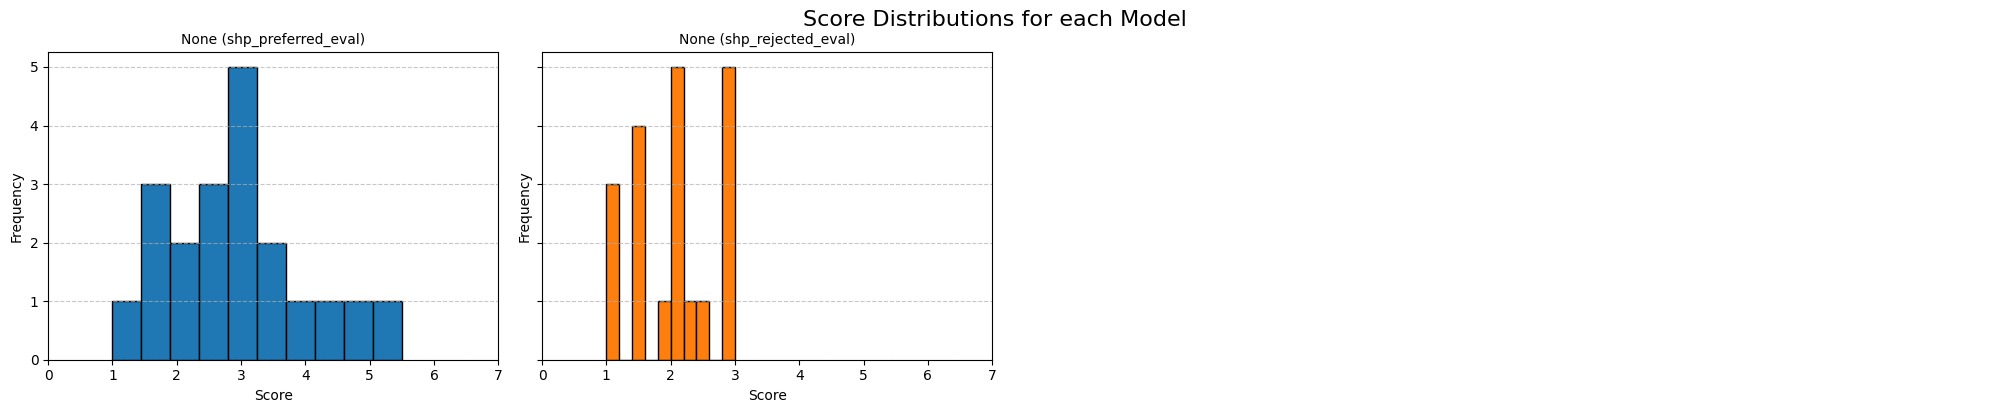

In [1]:
# Import the display_evaluation_summary function from the eval_utils script
from scripts.eval_utils import display_evaluation_summary
from scripts.config import RUN_IDS


# Load the completed evaluation IDs from the config file
preffered_eval_id = RUN_IDS["preffered_eval_id"] # loading a completed evaluation ID from config
rejected_eval_id = RUN_IDS["rejected_eval_id"] # loading a completed evaluation ID from config


# Display the evaluation summary
await display_evaluation_summary([preffered_eval_id, rejected_eval_id])

# 📈 Section 3: Evaluating Base Models

Now that we have a reliable AutoGrader set up, let's evaluate a variety of Azure OpenAI **base models** on our custom evaluation dataset.

---

### 🔍 Models Evaluated

We will compare the performance of six base models:

| Model | Description |
|:------|:------------|
| **o3** | Latest reasoning-optimized model |
| **gpt-4.1** | Production-grade GPT-4.1 |
| **o3-mini** | Smaller variant of o3 for efficiency |
| **gpt-4.1-mini** | Smaller variant of GPT-4.1 |
| **gpt-4o** | New lightweight GPT-4 omni model |
| **gpt-4o-mini** | Smaller variant of GPT-4o |

Each model will be evaluated on 500 prompts from our evaluation dataset, and scored using the AutoGrader (scoring from 1.0 to 7.0).

---

### 🛠️ Evaluation Setup

Since full evaluation runs can take time, we preload the existing **run IDs** and **file IDs** for each model into our notebook.  
This setup allows us to **load**, **analyze**, and **visualize** completed evaluation runs instantly for the demo.

✅ Evaluation API used: Azure OpenAI Evaluation APIs  
✅ Scoring powered by: AutoGrader (o3 model)  
✅ Threshold used for pass/fail analysis: **5.0**

---

### 📊 Analysis: Pass Percentage by Model

After running the evaluations, we compare **pass rates** — the percentage of responses for each model that score **≥ 5.0** (good or excellent) under the AutoGrader rubric.

*(Bar chart output below)*

> **Observation:**  
> - **o3** and **gpt-4.1** models show the highest pass rates, demonstrating strong alignment with user expectations.  
> - **Mini variants** and **gpt-4o** show lower pass percentages, highlighting potential areas for distillation and fine-tuning improvements.

---

### 📊 Analysis: Score Distributions Across Models

Next, we examine the **distribution of scores** for each model to understand:

- How tightly clustered or spread the responses are
- Which models consistently achieve higher-quality answers

*(Distribution plots output below)*

> **Observation:**  
> - **o3** responses are tightly clustered near 6.0 — very high quality.
> - **gpt-4.1** also shows strong concentration in the 5.0–6.0 range.
> - **Mini models** and **gpt-4o** show broader spread, indicating mixed performance — valuable candidates for future fine-tuning.

---

*(Coming up next: Distilling high-quality responses from top models to train smaller models! 🚀)*


> ⚙️ This cell defines the evaluation configuration and creates a reusable evaluation ID. We use `o3` as the AutoGrader and apply a pass threshold of **5.0** to raise the bar beyond SHP preferences.


In [ ]:
# Create a new evaluation

from scripts.eval_utils import create_eval

# Define the pass threshold and grader model
PASS_THRESHOLD = 5.0
GRADER_MODEL = "o3"  # Replace with your desired grader model

# Call the create_eval function
eval_id = await create_eval(PASS_THRESHOLD, GRADER_MODEL, "shp_base_eval_set_500_th_5")
print(f"Evaluation created with ID: {eval_id}")

Evaluation created successfully with ID: eval_6815c225c0b481909e9ab9d76ead26b3
Evaluation created with ID: eval_6815c225c0b481909e9ab9d76ead26b3


> 📤 We now launch evaluation runs for each model. These deployments are scored against the same 500 prompts using our configured `AutoGrader`.

In [4]:
from scripts.io_utils import upload_file
eval_file_id = await upload_file(file_name="shp_eval_set_prompts.jsonl", file_path="data/shp_eval_set_prompts.jsonl", purpose="evals")


Using Azure API for file upload...
File uploaded successfully to Azure.


In [ ]:
# Import the create_eval_run function from the eval_utils script
from scripts.eval_utils import create_eval_run


# Set your Model Deployment Names for the run
RUN_MODEL_DEPLOYMENTS = [
    "o3",
    "o3-mini",
    "gpt-4o",
    "gpt-4o-mini",
    "gpt-4.1",
    "gpt-4.1-mini",
]

# Create Eval Runs for each deployment
for deployment in RUN_MODEL_DEPLOYMENTS:
    await create_eval_run(eval_id, eval_file_id, deployment)

# Print the evaluation ID
print(f"Evaluation ID: {eval_id}")

Create Eval Run Status for gpt-4.1-mini: 201
Evaluation ID: eval_6815c225c0b481909e9ab9d76ead26b3


> 📥 Rather than waiting for all eval jobs to complete live, we fetch results from a previously completed evaluation using its `eval_id`.

Get Evaluation Runs: eval_6815c225c0b481909e9ab9d76ead26b3

Combined Evaluation Summary
                                  Run ID                Run Name        Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID            Evaluation Name
evalrun_6815c28503748190b0e1d180f8e0fd9f           AutoGrader_o3           o3 completed           95.757576                  1.0 eval_6815c225c0b481909e9ab9d76ead26b3 shp_base_eval_set_500_th_5
evalrun_6815c5eb03dc819095b493b57751316c      AutoGrader_gpt-4.1      gpt-4.1 completed           87.651822                  1.0 eval_6815c225c0b481909e9ab9d76ead26b3 shp_base_eval_set_500_th_5
evalrun_6815c456f0248190960fb3d2c02cccf0      AutoGrader_o3-mini      o3-mini completed           71.399594                  1.2 eval_6815c225c0b481909e9ab9d76ead26b3 shp_base_eval_set_500_th_5
evalrun_6815c625c288819094487a9bc5bccd1f AutoGrader_gpt-4.1-mini gpt-4.1-mini completed           58.502024                  1.0 eval_68

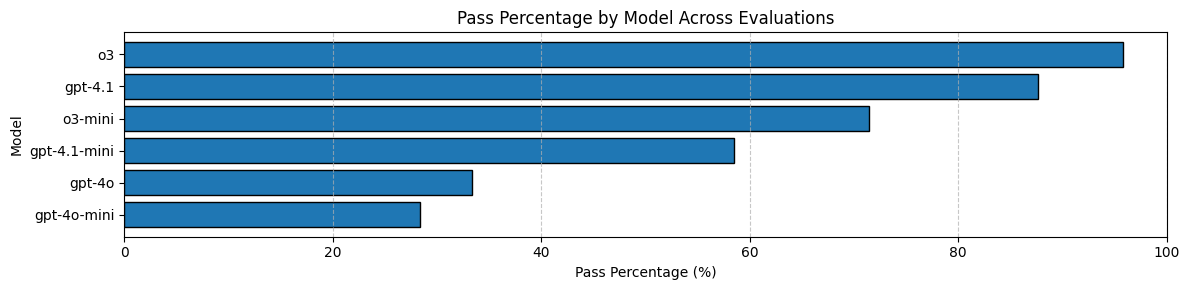


Score Summary Table:
       Model            Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
          o3 shp_base_eval_set_500_th_5          5.60      3.00      6.30            4.95            5.38            6.00            6.00            6.01
     gpt-4.1 shp_base_eval_set_500_th_5          5.33      3.00      6.00            4.90            5.15            5.50            5.80            6.00
     o3-mini shp_base_eval_set_500_th_5          5.04      3.00      6.00            4.35            4.95            5.25            5.50            5.71
      gpt-4o shp_base_eval_set_500_th_5          4.54      3.50      5.50            3.50            4.00            4.50            5.00            5.05
gpt-4.1-mini shp_base_eval_set_500_th_5          4.53      2.00      5.80            3.40            4.00            5.00            5.20            5.50
 gpt-4o-mini shp_base_eval_set_500_th_5          4.43 

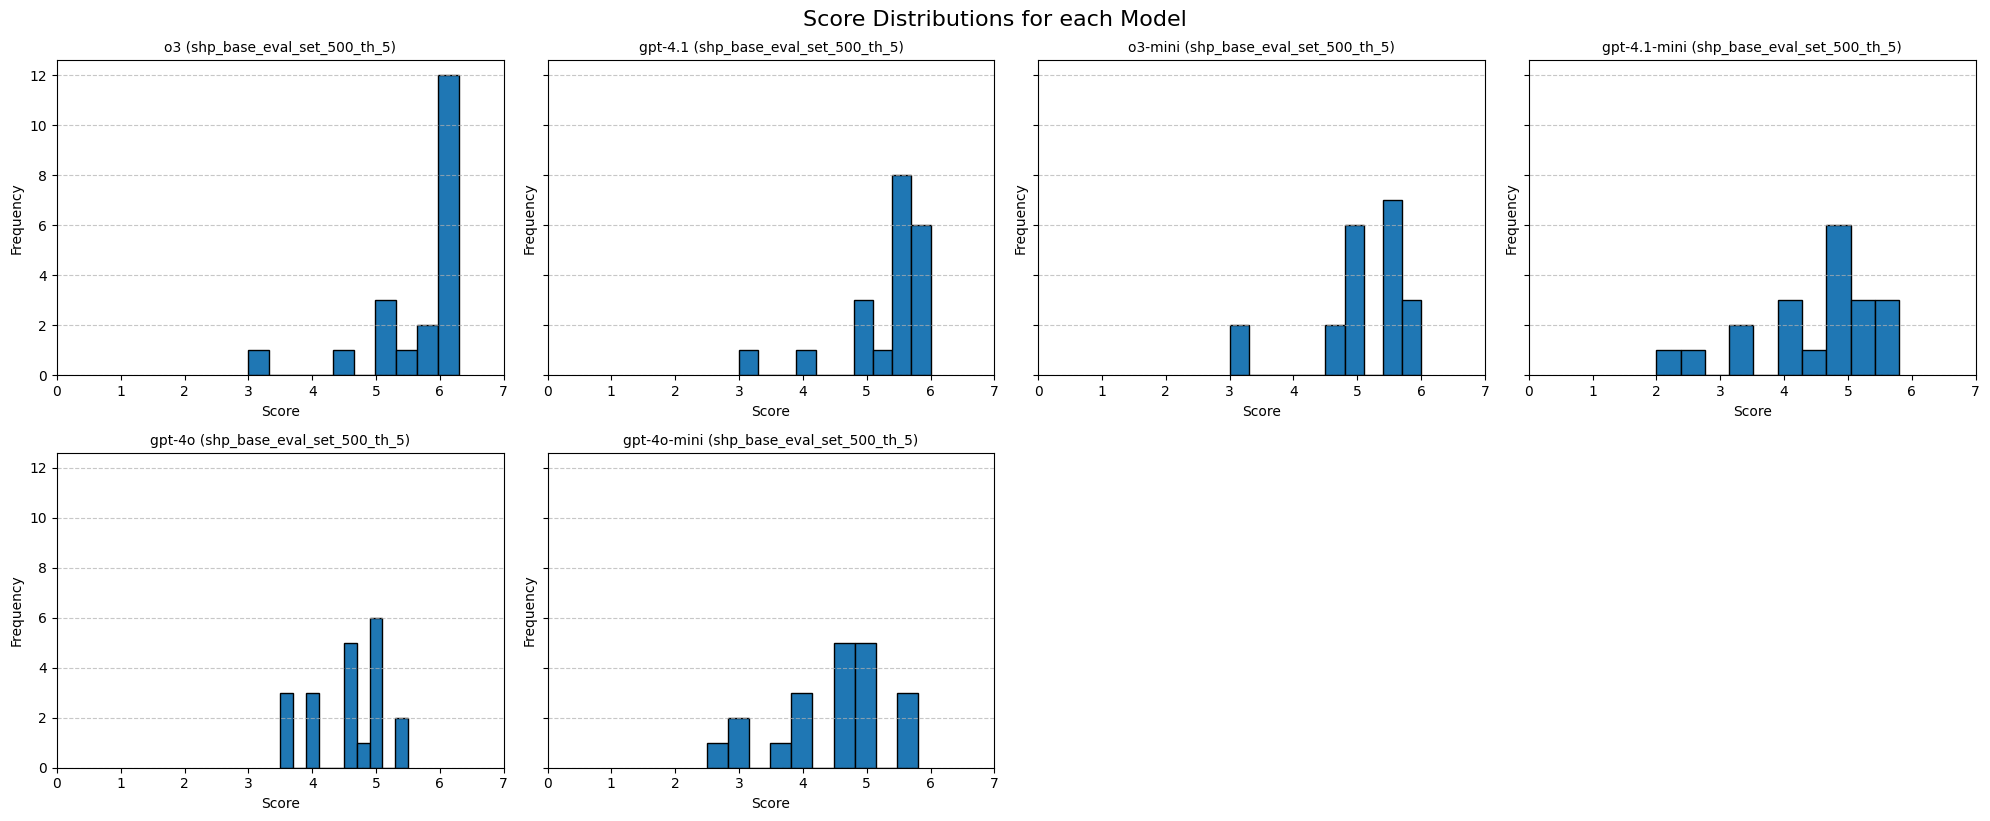

In [1]:
# Import the display_evaluation_summary function from the eval_utils script
from scripts.eval_utils import display_evaluation_summary
from scripts.config import RUN_IDS

# Load the completed evaluation IDs from the config file
eval_id = RUN_IDS["eval_id_500"]

# Display the evaluation summary
await display_evaluation_summary([eval_id])


# 🧪 Section 4: Distillation Setup

Now that we've evaluated the base models, we can move toward **distillation** — a technique to transfer knowledge from a strong "teacher" model into smaller, faster "student" models.

---

### 🧠 Why Distillation?

In our evaluations, the **o3 model** achieved the highest scores across the evaluation dataset, demonstrating the best alignment with user expectations.

✅ Therefore, we'll use **o3** as our **Teacher Model** for distillation.

The goal is simple:  
- **Capture** how the o3 model would respond to a given set of prompts.
- **Train** smaller models to mimic o3’s behavior as closely as possible.

By doing so, we can boost the quality of smaller models while maintaining their speed and cost advantages.

---

### 🛠️ Distillation Process for This Demo

We'll distill using our **Training Dataset** (1,000 prompts) that we created earlier.

The steps are:

1. **Use o3 to generate completions** for each training prompt.
2. **Save** the prompt and o3's completion into a fine-tunable dataset format.
3. Optionally, use Azure OpenAI's **Stored Completion** feature to automatically save these completions for future fine-tuning directly via the Azure UI.

> **Note:**  
> For this demo, we'll capture the completions locally and prepare a fine-tuning file manually.  
> In production setups, you can directly enable **Stored Completions** to gather live traffic data and distill on real-world prompts effortlessly.

---

### 🔄 Distillation Flow

![Distillation Process Diagram](images/md-distill-flow.png)

---

### ✨ Key Benefits of This Approach

- **Accelerated customization**: Small models learn best practices from the teacher without needing massive retraining.
- **Production ready**: Stored Completions allow seamless data gathering from real deployments.
- **Cost Efficiency**: Fine-tuned smaller models are faster and cheaper to run while maintaining high quality.

---

*(Coming up next: Fine-tuning smaller models on distilled data! 🚀)*


### Distillation dataset from o3 results using Stored Completions

In [3]:
# distill the dataset from teacher model using stored completions

from scripts.stored_completions_utils import process_and_store_completions


# Define parameters
TEACHER_MODEL = "o3"  # Replace with your teacher model
INPUT_PATH = "./data/train_set_1000.jsonl"  # Path to input file
OUTPUT_PATH = "./data/distilled_sc_output.jsonl"  # Path to output file


# Call the function
process_and_store_completions(
    input_path=INPUT_PATH,
    output_path=OUTPUT_PATH,
    model=TEACHER_MODEL,
    dataset_name="train_set_10",  # Optional: Metadata for dataset name
    author="Omkar",  # Optional: Metadata for author
    max_records=3,
    # wait_till_stored=True,
)

🔹 Loaded 3 records from data\train_set_1000.jsonl
⚠️ Output file data\distilled_sc_output.jsonl already exists. Deleting it.


Processing completions:   0%|          | 0/3 [00:00<?, ?it/s]

Processing completions: 100%|██████████| 3/3 [00:59<00:00, 19.72s/it]


✅ Done. Completions saved to: data\distilled_sc_output.jsonl


In [4]:
from scripts.distill_utils import convert_to_sft_format

convert_to_sft_format(
    input_path="data/distilled_sc_output.jsonl",
    output_path="data/train_sft_o3.jsonl",
    system_prompt="You are a helpful assistant. answer the queries",
)

🔹 Loaded 3 records for SFT conversion
✅ SFT-ready file saved to: data\train_sft_o3.jsonl — 3 records


## 📄 Previewing the Distilled Fine-Tuning Dataset

Now that we've completed the distillation step, let's take a quick look at a few examples from the **fine-tuning dataset** we created.

Each record consists of a **system prompt**, a **user query**, and the **o3 model's high-quality completion**.

This dataset will be used to fine-tune smaller models, helping them learn to produce outputs similar to the top-performing o3 model.

---

### 📦 Fine-Tuning Dataset Format

Each entry follows the standard Azure OpenAI fine-tuning format:

```json
{
  "messages": [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "<user's prompt here>"},
    {"role": "assistant", "content": "<model's high-quality completion here>"}
  ]
}


In [5]:
from scripts.distill_utils import preview_fine_tuning_dataset

# Path to your distilled fine-tuning file
sft_file_path = "./data/train_sft_o3_1000.jsonl"

# Preview the fine-tuning dataset
preview_fine_tuning_dataset(sft_file_path, num_samples=3, max_len=500)

,User Prompt,Assistant Response
0,"Question regarding using the blood plasma of recovered people to treat sick people: When the plasma is injected, is it just the antibodies in the donated plasma that attacks the virus, or does the body detect the antibodies and create more ?","Convalescent‑plasma therapy is an example of passive immunity. What is transferred are ready‑made antibodies (mainly IgG) that the donor produced while recovering from the infection. Those antibodies do three things in the recipient: 1. Immediately bind to free virus and block its entry into new cells (neutralisation). 2. Tag virus‑infected cells so that the patient’s own immune cells can destroy them (opsonisation, ADCC, complement activation). 3. Lower the overall viral load, giving the..."
1,"CMV: NFTs are digital garbage whose popularity is fueled by greedy speculation. We’ve seen this before… Hummel figurines, beanie babies, Thomas Kinkade ‘collectibles’. People will compete to spend money on tokens purely out of speculation under the misguided belief that “These are gonna be worth something someday.” With NFTs, I don’t believe there is any true value to them and as a medium, I do not believe they will have lasting artistic significance. My current take is that NFTs are an offsho...",I won’t try to persuade you that every Bored Ape or pixel‑art penguin is destined to appreciate in price—most of them probably won’t. But “most current examples are hype‑driven” is different from “the entire medium is worthless.” Below are some angles that often get missed when NFTs are dismissed as Beanie‑Baby‑with‑JPEGs. ────────────────────────────────── 1. What an NFT actually is ────────────────────────────────── • A blockchain entry that says “address 0xABC owns token #123.” • The token...
2,"What judgment should I make when I encounter claims that have neither supporting evidence nor counterevidence? Suppose someone claims that a unicorn exists, and there is no evidence for or against the existence of a unicorn, what should a rational thinker do in such scenario? Should one suspend judgment? Or should one reason that the claim is more likely to be false since it is a better explanation in terms of simplicity?","There are three different things you might mean by “what judgment should I make?” 1. Should I positively believe that the claim is true? 2. Should I positively believe that the claim is false? 3. How much credence (degree of confidence) should I assign to the claim while I wait for further evidence? The answer depends on which of the above is at issue, but the general rules used by most contemporary epistemologists, logicians of science and probability theorists line up as follows. ------..."


# 🛠️ Section 5: Fine-Tuning Setup

Now that we have our distilled dataset ready, the next step is to **fine-tune smaller models** to match the high-quality behavior of the `o3` teacher model.

The goal is to **boost the performance of smaller, faster models** while maintaining cost and latency advantages.


### 🧠 Models to Fine-Tune

We’ll fine-tune the following Azure OpenAI base models:

| **Model Name**    | **Model Version**          |
|-------------------|----------------------------|
| `gpt-4o`          | `gpt-4o-2024-08-06`        |
| `gpt-4.1`         | `gpt-4.1-2025-04-14`       |
| `gpt-4.1-mini`    | `gpt-4.1-mini-2025-04-14`  |


### 🚀 Fine-Tuning Setup

- We’ll start by launching a fine-tuning run for `gpt-4.1` via **Azure Studio UI** using Stored Completions.
- Then we’ll switch to **code** to kick off fine-tuning for additional models (`gpt-4o`, `gpt-4.1-mini`).
- The training dataset used is our **distilled dataset** from Section 4.
- By default, Azure selects optimized **hyperparameters**, but we’ll show how to override them if needed.


### ⚙️ Fine-Tuning Hyperparameters

Here are the key controls available when configuring a fine-tuning job:

| **Hyperparameter**         | **Purpose**                                | **Example Default**                     |
|----------------------------|---------------------------------------------|------------------------------------------|
| `batch_size`               | Number of examples per training step        | Auto-selected (based on dataset size)   |
| `learning_rate_multiplier`| Scales the base learning rate               | Auto-selected                            |
| `n_epochs`                | Number of passes over the dataset           | Auto-selected                            |

✅ By default, Azure chooses optimal values.  
🛠️ But you can override them to control convergence speed, generalization, or training cost.

```python
# Example: custom hyperparameters
hyperparameters = {
    "batch_size": 8,
    "learning_rate_multiplier": 0.05,
    "n_epochs": 4
}


### Fine Tune the student Model

In [ ]:
# upload the distilled dataset
from scripts.io_utils import upload_file

# Define the file name and path
FILE_NAME = "train_sft_o3_1000.jsonl"

FILE_PATH = "./data/train_sft_o3_1000.jsonl"

# Call the upload_file function
train_file_id = await upload_file(FILE_NAME, FILE_PATH, purpose="fine-tune")

# Print the file ID
print(f"File ID: {train_file_id}")

In [ ]:
# kick off the fine-tune job

from scripts.finetune_utils import create_finetune_sft

# Example: Create a fine-tuning job with custom supervised configuration
training_file_id = train_file_id  # Replace with your training file ID

# model = "gpt-4o-2024-08-06"  # Replace with your base model
model = "gpt-4.1-2025-04-14"
# model = "gpt-4.1-mini-2025-04-14"


suffix = "o3-1000"  # Optional suffix for the fine-tuned model


# Custom hyperparameters
hyperparameters = {
    "batch_size": 1,
    "learning_rate_multiplier": 2.0,
    "n_epochs": 3,
}


# Create the supervised fine-tuning job with default
finetune_id = create_finetune_sft(training_file_id, model, suffix) # optionally add hyperparameters


In [ ]:
# print the finetune job details
from scripts.finetune_utils import print_finetune_details

print_finetune_details(finetune_id)

# 📈 Section 6: Evaluation After Fine-Tuning

After fine-tuning our smaller models using the distilled dataset, it’s important to **re-evaluate** them using the same evaluation setup.

The goal is to measure **how much performance improvement** we've achieved through distillation and fine-tuning.

---

### 🧠 Evaluation Setup

- Evaluations are run on the **same 500-prompt evaluation dataset**.
- Scoring is done using the **same AutoGrader** (based on the o3 model).
- Threshold for pass/fail: **5.0**.

We compare:
- **Base Models** (before fine-tuning)
- **Fine-Tuned Models** (after fine-tuning)

*(Fine-tuned model names start with `ft-`.)*

---

### 📊 Pass Percentage by Model

The bar chart below shows the **pass percentage** (responses scoring ≥ 5.0) across all models:

*(Chart output below)*

> **Observations:**  
> - Fine-tuned models (in orange) show significant improvement over their corresponding base models.
> - Fine-tuned **gpt-4.1** and **gpt-4o** variants move closer to o3's performance level.
> - Fine-tuning boosts smaller models' pass rates substantially, making them much more viable for production usage.

---

### 📊 Score Distributions Across Models

We also analyze **score distributions** to better understand:

- How scores are clustered (tight or spread out)
- Shifts in score quality after fine-tuning

*(Distribution plots output below)*

> **Observations:**  
> - Fine-tuned models show a noticeable shift toward higher scores.
> - Variance is reduced for fine-tuned models, indicating **more consistent quality**.
> - Some smaller models (like **gpt-4.1-mini**) show major gains after fine-tuning.

---

### 🎯 Key Takeaways

- Fine-tuning smaller models on distilled o3 completions **significantly improves** their quality.
- **Pass percentages** rise sharply after fine-tuning, demonstrating effective knowledge transfer.
- **Fine-tuned smaller models** can now offer an attractive **balance between performance, speed, and cost** compared to large teacher models.

---

*(Coming up next: Detailed cost vs performance comparison to select best deployment candidates! 🚀)*


In [19]:
# Create a new evaluation

# Import the create_eval function from the eval_utils script
from scripts.eval_utils import create_eval

# Define the pass threshold and grader model
PASS_THRESHOLD = 5.0
GRADER_MODEL = "o3"  # Replace with your desired grader model

# Call the create_eval function
ft_eval_id = await create_eval(PASS_THRESHOLD, GRADER_MODEL, "shp_ft_eval_set_500_th_5")

# Print the evaluation ID
if ft_eval_id:
    print(f"Evaluation created with ID: {eval_id}")
else:
    print("Failed to create evaluation.")

Evaluation created successfully with ID: eval_6815c76a9e088190bddc2e31e0a3f338
Evaluation created with ID: eval_6815c225c0b481909e9ab9d76ead26b3


In [21]:
# Import the create_eval_run function from the eval_utils script
from scripts.eval_utils import create_eval_run


ft_model_4o_o3_1000 = RUN_IDS["ft_model_4o_o3_1000"]
ft_model_41_o3_1000 = RUN_IDS["ft_model_41_o3_1000"]
ft_model_41_mini_o3_1000 = RUN_IDS["ft_model_41_mini_o3_1000"]

# Set your Model Deployment Names for the run
RUN_MODEL_DEPLOYMENTS = [
    # ft_model_41_o3_1000,
    ft_model_41_mini_o3_1000,
    ft_model_4o_o3_1000,
]

# Create Eval Runs for each deployment
for deployment in RUN_MODEL_DEPLOYMENTS:
    await create_eval_run(ft_eval_id, eval_file_id, deployment)

# Print the evaluation ID
print(f"Evaluation ID: {ft_eval_id}")

Create Eval Run Status for ft-gpt-41-mini-o3-1000: 201
Create Eval Run Status for ft-gpt-4o-o3-1000: 201
Evaluation ID: eval_6815c76a9e088190bddc2e31e0a3f338


Get Evaluation Runs: eval_6815c225c0b481909e9ab9d76ead26b3
Get Evaluation Runs: eval_6815c76a9e088190bddc2e31e0a3f338

Combined Evaluation Summary
                                  Run ID                          Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID            Evaluation Name
evalrun_6815c28503748190b0e1d180f8e0fd9f                     AutoGrader_o3              o3 completed           95.757576                  1.0 eval_6815c225c0b481909e9ab9d76ead26b3 shp_base_eval_set_500_th_5
evalrun_6815c784ce20819083cd063401e0631a      AutoGrader_ft-gpt-41-o3-1000 ft-gpt-41-o3-10 completed           89.755011                  9.8 eval_6815c76a9e088190bddc2e31e0a3f338   shp_ft_eval_set_500_th_5
evalrun_6815c5eb03dc819095b493b57751316c                AutoGrader_gpt-4.1         gpt-4.1 completed           87.651822                  1.0 eval_6815c225c0b481909e9ab9d76ead26b3 shp_base_eval_set_500_th_5
evalrun_6815c993b82481909

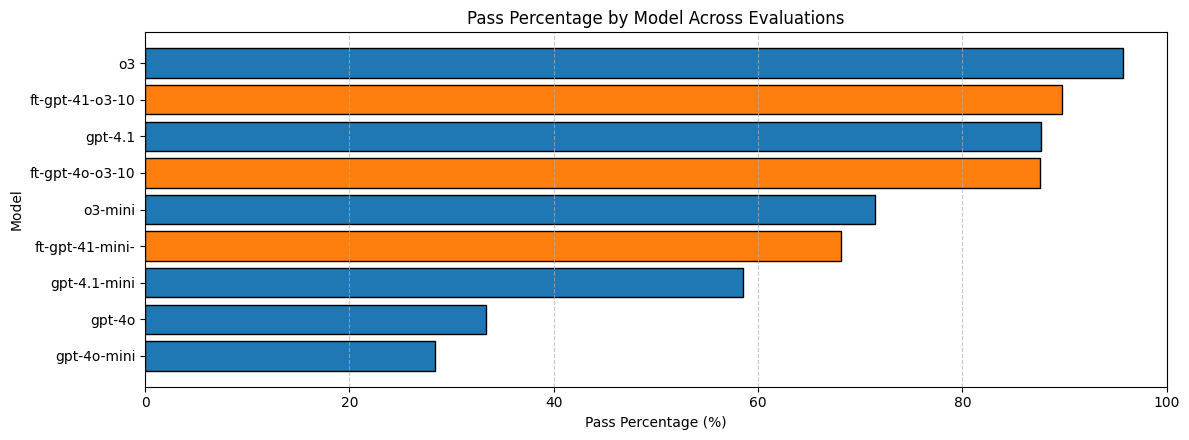


Score Summary Table:
          Model            Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
             o3 shp_base_eval_set_500_th_5          5.60      3.00      6.30            4.95            5.38            6.00            6.00            6.01
        gpt-4.1 shp_base_eval_set_500_th_5          5.33      3.00      6.00            4.90            5.15            5.50            5.80            6.00
        o3-mini shp_base_eval_set_500_th_5          5.04      3.00      6.00            4.35            4.95            5.25            5.50            5.71
         gpt-4o shp_base_eval_set_500_th_5          4.54      3.50      5.50            3.50            4.00            4.50            5.00            5.05
   gpt-4.1-mini shp_base_eval_set_500_th_5          4.53      2.00      5.80            3.40            4.00            5.00            5.20            5.50
    gpt-4o-mini shp_base_eval_set_50

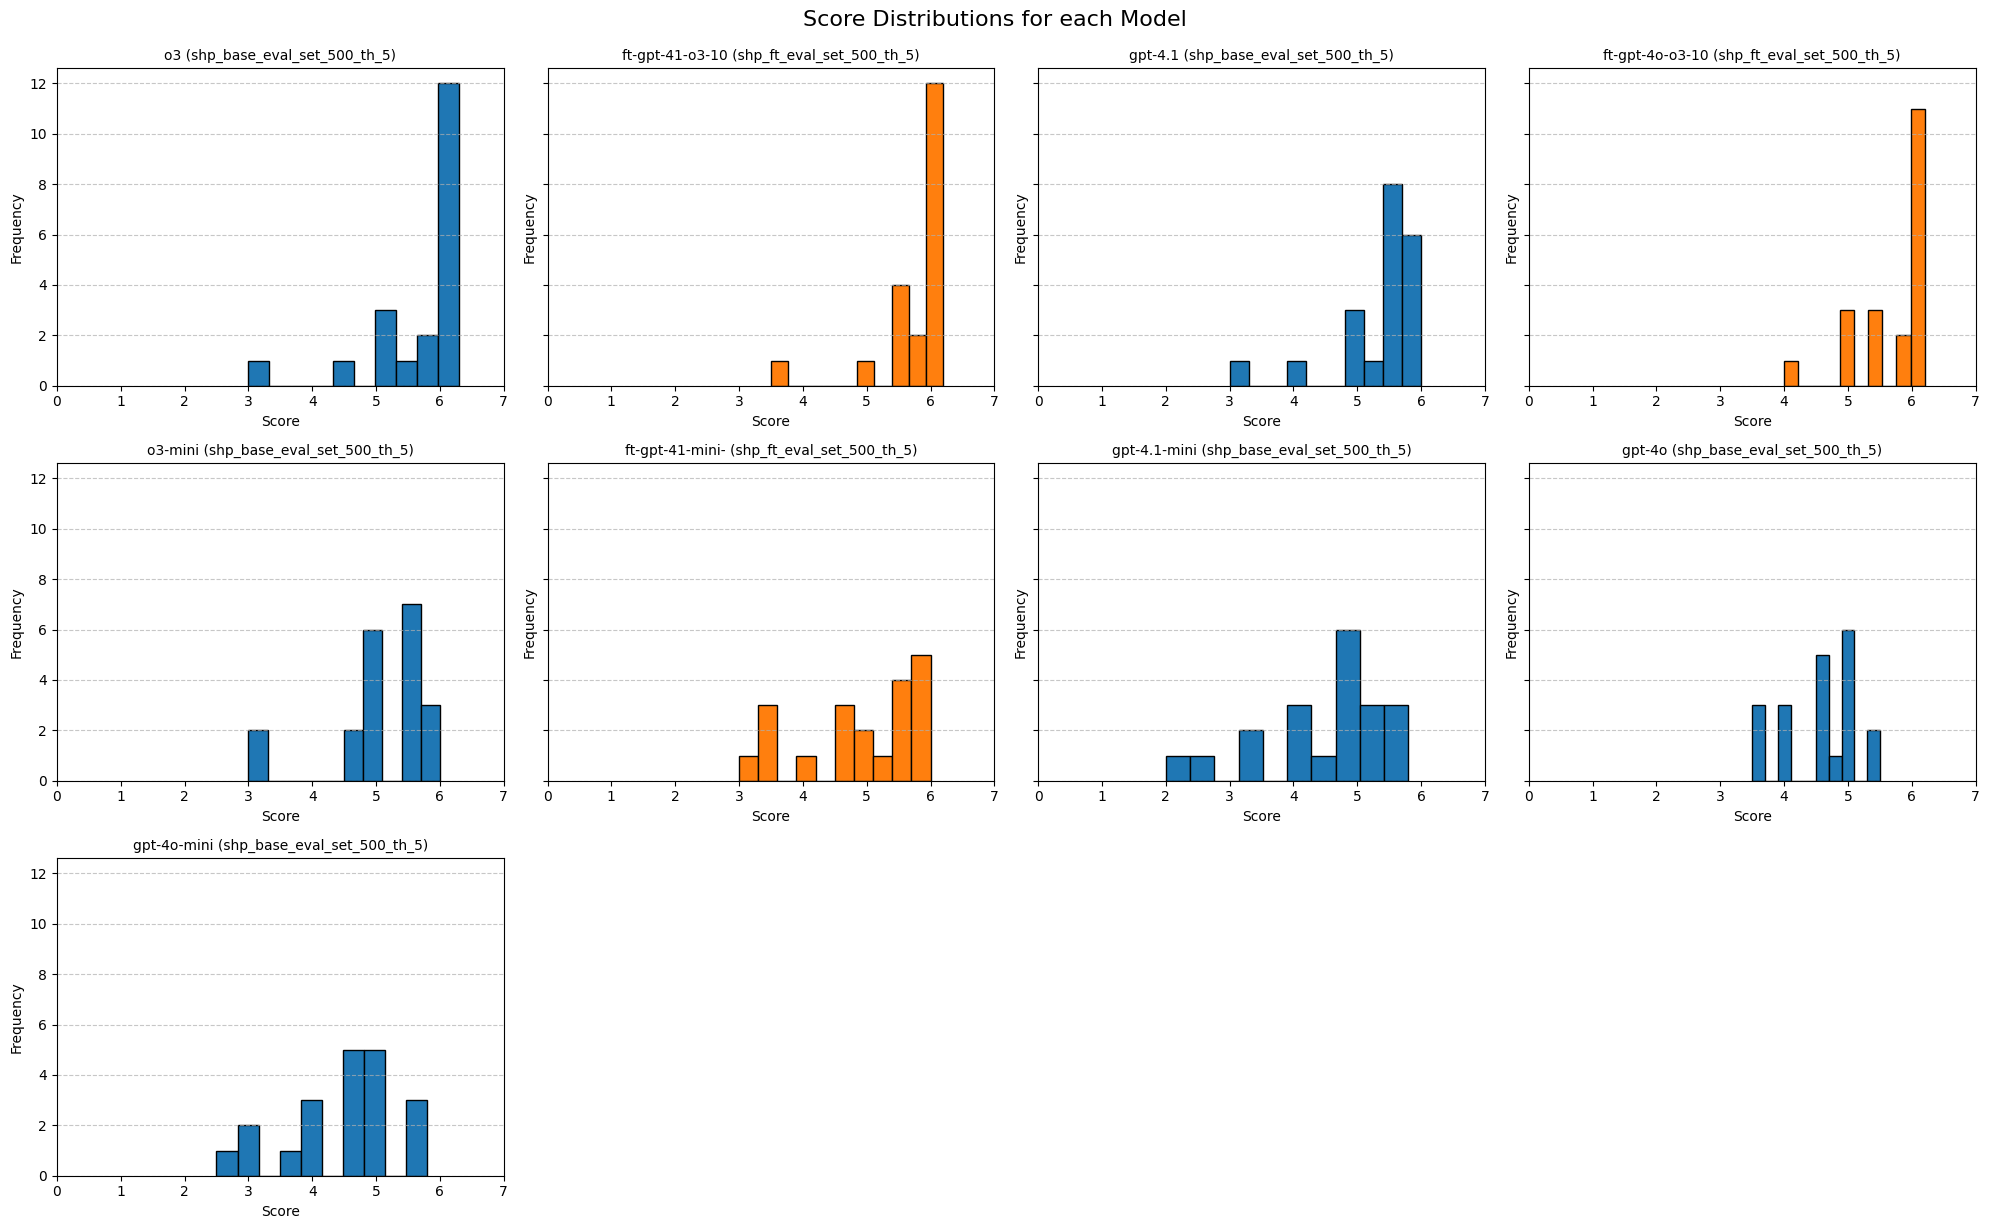

In [23]:
# Import the display_evaluation_summary function from the eval_utils script
from scripts.eval_utils import display_evaluation_summary

# Display the evaluation summary
eval_ids = [eval_id, ft_eval_id]
await display_evaluation_summary(eval_ids)

| Model                | Base vs FT | Observations |
|---------------------|------------|--------------|
| `gpt-4.1` vs `ft:gpt-4.1` | ✅ FT wins | Clear improvement in pass rate and tighter distribution |
| `gpt-4o` vs `ft:gpt-4o` | ✅ FT wins | Similar trend — boosted helpfulness, aligned tone |
| `gpt-4.1-mini` vs `ft:gpt-4.1-mini` | ✅ FT wins | Notable gain for a small model |
| `o3`                 | Benchmark  | Still the gold standard, but now closely matched by fine-tuned models |

# 💸 Section 7: Cost vs Performance Comparison

Now that we've fine-tuned smaller models, it's important to evaluate their **cost-effectiveness** compared to base models.

---

### 🧠 Pricing Assumptions (April 2025)

| Model          | Input Cost (per 1M tokens) | Output Cost (per 1M tokens) | Hosting Cost | Notes |
|:---------------|:---------------------------|:----------------------------|:-------------|:------|
| **o3**         | $15                         | $60                         | None         | 80:20 input:output ratio assumed |
| **gpt-4.1**    | $2.75                       | $11                         | None         | |
| **ft-gpt-4.1** | $2.75                       | $11                         | $1.7/hour    | |

---

### 📈 Cost Analysis Methodology

- **Token ratio**: 80% input tokens, 20% output tokens
- **Cost per 1M tokens**:
  - **o3**: $24
  - **gpt-4.1**: $4.40
  - **ft-gpt-4.1**: $4.40 + $1.7 hosting/hour
- **TPM Range**: 100 to 1 Million tokens per minute
- **Hosting Cost**: Fixed $1.7/hour for fine-tuned models
- **Inference Cost**: Scales linearly with token usage

---

### 📊 Cost Comparison Graph

*(Graph output below)*

- **X-axis**: Tokens per Minute (TPM) — log scale
- **Y-axis**: Total Cost per Hour (USD)

The graph compares:
- **o3 (Base Model)**
- **gpt-4.1 (Base Model)**
- **ft-gpt-4.1 (Fine-Tuned Model)**

---

### 🎯 Break-Even Analysis

- **Break-even Point**:  
  - At around **1,200 Tokens per Minute**, **ft-gpt-4.1** becomes **cheaper** than **o3**.
- **Interpretation**:  
  - For **low-traffic** scenarios (<1,200 TPM), base o3 may be cheaper.
  - For **higher-traffic** scenarios (>1,200 TPM), **fine-tuning pays off** by offering lower costs while maintaining high quality.

---

### 🏆 Key Insights

- **Fine-tuned models** are extremely cost-efficient at scale.
- **Hosting cost** becomes negligible compared to inference cost at moderate to high TPM.
- **Base gpt-4.1** remains the cheapest option if fine-tuning isn't needed.
- **Base o3** is significantly more expensive at any scale.

---

*(Coming up next: Final Thoughts and Recommendations! 🚀)*


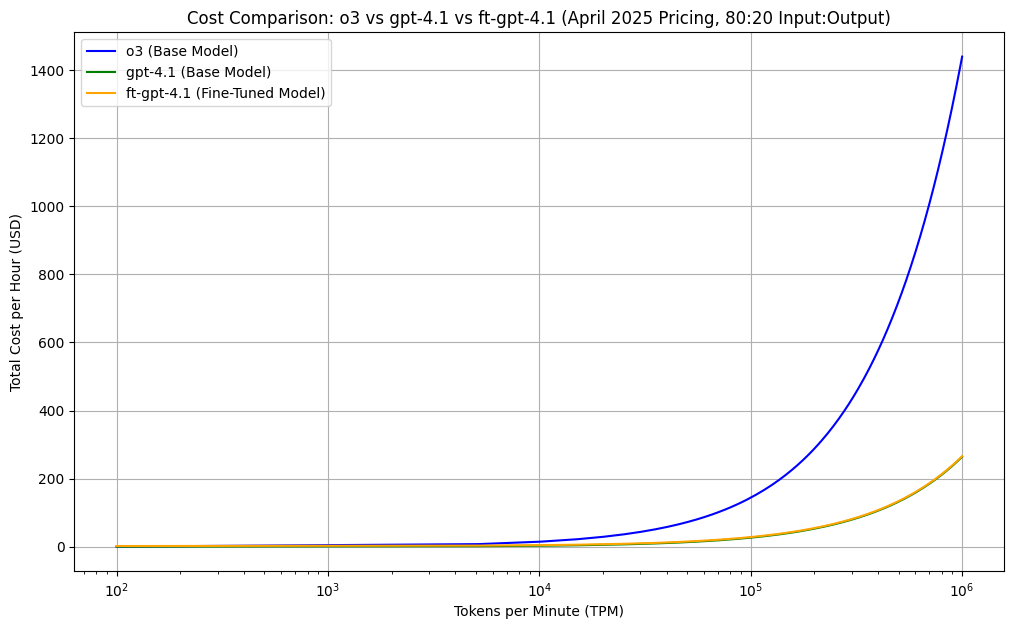

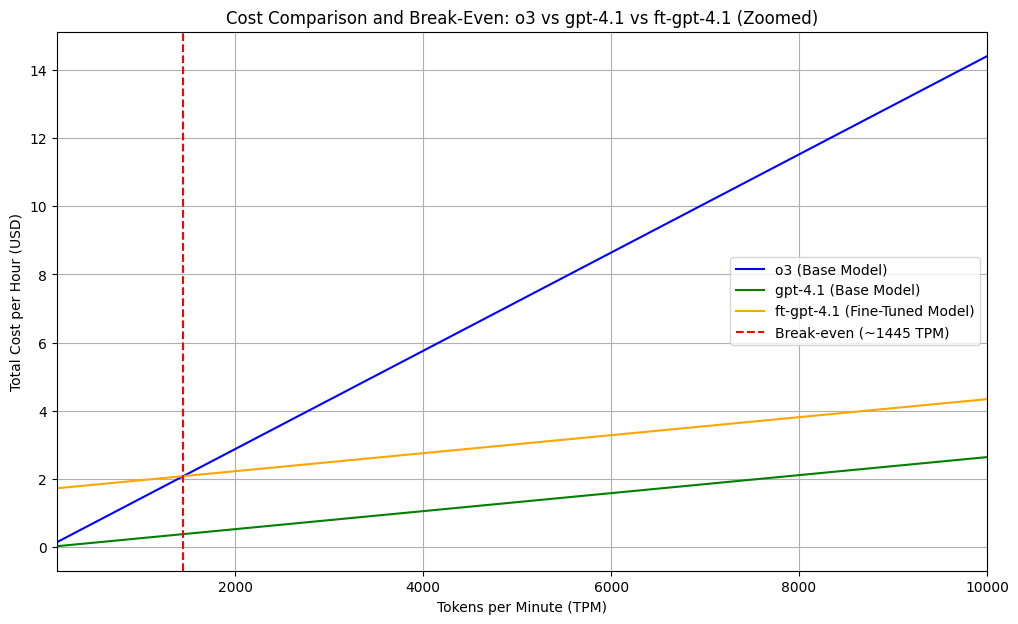

In [6]:
from scripts.cost_util import plot_cost_comparison, plot_cost_break_even

# Plot the cost comparison
plot_cost_comparison()

# Plot the cost break-even analysis
plot_cost_break_even()

# 🏁 Final Thoughts and Recommendations

Over the course of this demo, we explored a complete **Customization Workflow for Azure OpenAI Models**, from evaluation to distillation to fine-tuning and final cost analysis.

---

### 🔍 What We Learned

- **Evaluation**: Using the new Azure OpenAI Evaluation APIs and AutoGrader, we systematically assessed model performance on a real-world task.
- **Distillation**: We extracted high-quality completions from a strong teacher model (**o3**) to create a distilled fine-tuning dataset.
- **Fine-Tuning**: We fine-tuned smaller models (**gpt-4.1**, **gpt-4.1-mini**) to replicate the teacher's performance while optimizing for efficiency.
- **Evaluation After Fine-Tuning**: Fine-tuned models showed significant gains in pass rates, moving closer to o3 quality while being much lighter.
- **Cost Analysis**: 
  - **o3** is powerful but expensive.
  - **Base gpt-4.1** models offer a strong cost advantage.
  - **Fine-tuned gpt-4.1** models become highly cost-effective at moderate to high traffic (break-even around **1200 Tokens per Minute**).
  
---

### 💡 Recommendations for Production Deployments

| Scenario | Best Option | Why |
|:---------|:------------|:----|
| **Low traffic applications** | Base **gpt-4.1** | Lowest upfront cost, no hosting overhead |
| **Medium to high traffic (1200+ TPM)** | **Fine-tuned gpt-4.1** | Fine-tuning investment pays off, significant cost savings |
| **Performance-critical applications** | Fine-tuned smaller models (gpt-4.1-mini) | Balance between speed, quality, and price |
| **Budget-sensitive but quality-needed apps** | Fine-tuned models with distillation | Close to best model performance at fraction of the cost |

---

### 🎯 Key Takeaways

- Fine-tuning **small, cost-efficient models** on distilled datasets is an extremely powerful customization lever.
- **Hosted fine-tuned models** become more economical at **moderate to high scale**.
- Azure OpenAI's tooling — **Evaluation APIs**, **Stored Completions**, **Fine-Tuning** — enables a **smooth end-to-end production pipeline**.

---

### 🚀 What's Next?

- Explore **parameter tuning** (batch size, learning rate) to squeeze even more gains.
- Investigate **multi-task distillation** across datasets for broader generalization.
- Leverage **Stored Completions** to continuously improve production deployments automatically.

---

# 🙌 Thank you!

*(Happy Fine-Tuning! 🚀✨)*
![Final Slide](images/md-final.png)

In [ ]:
# read oai_api_type from .env file
from dotenv import load_dotenv
import os
load_dotenv()
oai_api_type = os.getenv("OAI_API_TYPE")

from scripts.config import RUN_IDS

# Access the required IDs
eval_id_500 = RUN_IDS["eval_id_500"]
file_id_500 = RUN_IDS["file_id_500"]
ft_eval_id_500 = RUN_IDS["ft_eval_id_500"]

train_file_id_o3_1000 = RUN_IDS["train_file_id_o3_1000"]

finetune_id_4o_o3_1000 = RUN_IDS["finetune_id_4o_o3_1000"]
finetune_id_41_mini_o3_1000 = RUN_IDS["finetune_id_41_mini_o3_1000"]
finetune_id_41_o3_1000 = RUN_IDS["finetune_id_41_o3_1000"]

ft_model_4o_o3_1000 = RUN_IDS["ft_model_4o_o3_1000"]
ft_model_41_o3_1000 = RUN_IDS["ft_model_41_o3_1000"]
ft_model_41_mini_o3_1000 = RUN_IDS["ft_model_41_mini_o3_1000"]


eval_id = eval_id_500
file_id = file_id_500
ft_eval_id = ft_eval_id_500

train_file_id = train_file_id_o3_1000
finetune_id = finetune_id_41_mini_o3_1000

# Print the API type for confirmation
print(f"oai_api_type: {os.getenv('OAI_API_TYPE', 'azure').lower()}")
# Example usage
print(f"Evaluation ID (500): {eval_id}")



In [ ]:
# Import the display_evaluation_summary function from the eval_utils script
from scripts.eval_utils import display_evaluation_summary

# Display the evaluation summary
eval_ids = [eval_id]
await display_evaluation_summary(eval_ids)